In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')
!cd gdrive/MyDrive/DataMining/Progetto

Mounted at /content/gdrive/
/bin/bash: line 0: cd: gdrive/MyDrive/DataMining/Progetto: No such file or directory


In [2]:
import networkx as nx
import pandas as pd
import json
from tqdm import tqdm_notebook as tqdm

In [3]:
!pip install crossrefapi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for crossrefapi: filename=crossrefapi-1.5.0-py3-none-any.whl size=15716 sha256=7636f44882d7c0aee26ec9e95916093eed2644f7f9a8cc713833be99cfc4ccd2
  Stored in directory: /root/.cache/pip/wheels/6b/80/c9/1858fe009591baf8a4406f169332897b51576f129803584326
Successfully built crossrefapi


In [4]:
import requests
from bs4 import BeautifulSoup
import csv
import re
from tqdm import tqdm
from crossref.restful import Works
import time

In [5]:
data=pd.read_json('/content/gdrive/MyDrive/DataMining/progetto/datasets/dataset_raw_7001.json')
data

,DOI,Title,First_author,Nation,Publish_time,Journal,Topic,URL,reference_to,PMID,citedBy
0,10.1186/s40635-019-0284-8,Aortic volume determines global end-diastolic ...,Akohov,Germany,2020-01-02,Intensive Care Med Exp,Hospital Care,http://dx.doi.org/10.1186/s40635-019-0284-8,"[10.1186/s13054-017-1739-5, 10.1097/EJA.000000...",31897796,"[35760382, 34775842, 33573169]"
1,10.1371/journal.pone.0226483,Risk perception and behavioral change during e...,Abdulkareem,Netherlands,2020-01-06,PLoS One,Societal response,http://dx.doi.org/10.1371/journal.pone.0226483,"[10.1057/hs.2014.22, 10.1093/her/cyg074, 10.10...",31905206,"[35761390, 35722244, 35444590, 35329823, 35070..."
2,10.1186/s12879-019-4724-6,Effect of prior receipt of antibiotics on the ...,Li,China,2020-01-06,BMC Infect Dis,Hospital Care,http://dx.doi.org/10.1186/s12879-019-4724-6,"[10.1093/cid/cis1021, 10.1016/0732-8893(87)901...",31906848,"[34625886, 34621317]"
3,10.1186/s12936-019-3096-0,Genetic polymorphisms in malaria vaccine candi...,Ajibaye,Niger,2020-01-06,Malar J,Hospital Care,http://dx.doi.org/10.1186/s12936-019-3096-0,"[10.1038/415673a, 10.1016/j.vaccine.2016.10.04...",31906953,"[35737709, 34162366, 33500482, 32630804]"
4,10.1186/s13756-019-0669-1,Enhanced infection control interventions reduc...,Phan,Vietnam,2020-01-07,Antimicrob Resist Infect Control,Viral molecular biology,http://dx.doi.org/10.1186/s13756-019-0669-1,"[10.1093/cid/cir257, 10.1016/j.jhin.2010.09.01...",31921415,"[35795519, 33434666]"
...,...,...,...,...,...,...,...,...,...,...,...
6987,10.1093/cid/ciaa1419,Risk Factors for COVID-19-associated hospitali...,Ko,United States of America,2020-09-18,Clin Infect Dis,Hospital Care,http://dx.doi.org/10.1093/cid/ciaa1419,"[10.1056/NEJMoa2002032, 10.1136/bmj.m1985, 10....",32945846,"[36050992, 36046662, 36042485, 35897262, 35885..."
6988,10.1016/j.tins.2020.10.006,Neuroethical and Societal Challenges of 21st C...,Minielly,Canada,2020-10-22,Trends Neurosci,Societal response,http://dx.doi.org/10.1016/j.tins.2020.10.006,"[10.1016/j.jns.2020.116884, 10.3390/ijerph1718...",33153756,[33935846]
6989,10.18632/oncotarget.27819,Treatment of elderly patients with refractory/...,Xavier,Brazil,2020-11-24,Oncotarget,Societal response,http://dx.doi.org/10.18632/oncotarget.27819,"[10.1056/NEJMra1011442, 10.1200/JCO.2008.20.89...",33316011,[34043442]
6990,10.1016/j.ijid.2019.10.009,Epidemiological characteristics and phylogenic...,Luo,China,2020-01-31,International Journal of Infectious Diseases,Hospital Care,http://dx.doi.org/10.1016/j.ijid.2019.10.009,"[10.1590/S0074-02762005000300001, 10.1007/s007...",31634614,"[35875547, 35632566, 34532066, 34425845, 34131..."


In [6]:
data = data[['DOI', 'reference_to', 'citedBy', 'PMID']]

In [7]:
dois = data['DOI'].tolist()
pmids = data['PMID'].tolist()
C_BY = data["citedBy"]
print(len(dois))
print(len(pmids))
print(len(C_BY))

6992
6992
6992


In [8]:
G = nx.DiGraph()

In [9]:
def doi_from_pmid(pmid):
  root = "https://www.ncbi.nlm.nih.gov/pmc/utils/idconv/v1.0/?email=vennerigiacomo98@gmail.com&"
  page = requests.get(root+"ids="+pmid)
                   
  if (page.status_code == 200):
      soup = BeautifulSoup(page.content, 'html.parser')
      records = str(soup.findAll("record"))
      cby_dois=re.findall(r'(?<=doi=")([^ ]*)(?=" )',records)
      if(len(cby_dois) >0): return cby_dois[0]
  else:
      print("errore", pmid)

In [10]:
doi_from_pmid("34625886")

'10.1007/s10096-021-04354-8'

In [11]:
for i in tqdm(data.iterrows()):
  node = i[1]["DOI"]
  node_pmid = i[1]["PMID"]
  
  for j in i[1]["reference_to"]:
    if( j in dois and j!=node):
      G.add_node(node)
      G.add_edge(node, j)
  for j in i[1]["citedBy"]:
    if( j in pmids and j!=node_pmid):
      current_doi = doi_from_pmid(j)
      if(j is not None):
        G.add_node(node)
        G.add_edge(current_doi, node)
        

print("Nodi: ",len(G.nodes()))
print("Archi: ",len(G.edges()))

6992it [01:56, 59.98it/s]

Nodi:  746
Archi:  621


In [12]:
#be sure that duplicates doesnèt exists
G.remove_edges_from(nx.selfloop_edges(G))
print("Nodi: ",len(G.nodes()))
print("Archi: ",len(G.edges()))

Nodi:  746
Archi:  621


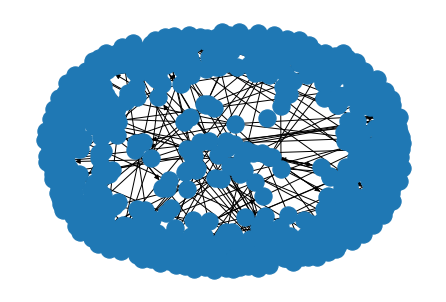

In [13]:
nx.draw(G)

In [14]:
between = nx.algorithms.centrality.betweenness_centrality(G)
df_between = pd.DataFrame(columns = ['DOI', 'betweennes'])
for i in between.keys():
  df_between = df_between.append({'DOI' : i, 'betweennes' : between[i]}, ignore_index = True)

column = "betweennes"
df_between[column] = df_between[column] /df_between[column].abs().max()
df_between[column]

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
741    0.0
742    0.0
743    0.0
744    0.0
745    0.0
Name: betweennes, Length: 746, dtype: float64

In [ ]:
data_out = df_between.to_json(orient = "records")
data_out = json.loads(data_out)
with open('dataset_between_7001_v3.json', 'w') as f:
    json.dump(data_out, f, indent = 4)

In [15]:
#only for direceted graphs
in_deg = nx.algorithms.centrality.in_degree_centrality(G)
df_in_deg = pd.DataFrame(columns = ['DOI', 'in_deg'])
for i in in_deg.keys():
  df_in_deg = df_in_deg.append({'DOI' : i, 'in_deg' : in_deg[i]}, ignore_index = True)

column = "in_deg"
df_in_deg[column] = df_in_deg[column] /df_in_deg[column].abs().max()
df_in_deg[column]

0      0.03125
1      0.00000
2      0.03125
3      0.00000
4      0.03125
        ...   
741    0.00000
742    0.00000
743    0.03125
744    0.06250
745    0.00000
Name: in_deg, Length: 746, dtype: float64

In [ ]:
data_out = df_in_deg.to_json(orient = "records")
data_out = json.loads(data_out)
with open('dataset_indeg_7001_v3.json', 'w') as f:
    json.dump(data_out, f, indent = 4)